# Сингулярное разложение матриц #
### и его применение в задачах восстановления регрессии ###

> Данный ноутбук практически полностью основан на курсе лекций К.В. Воронцова [&laquo;Машинное обучение&raquo;](http://www.machinelearning.ru/wiki/index.php?title=%D0%9C%D0%B0%D1%88%D0%B8%D0%BD%D0%BD%D0%BE%D0%B5_%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5_%28%D0%BA%D1%83%D1%80%D1%81_%D0%BB%D0%B5%D0%BA%D1%86%D0%B8%D0%B9%2C_%D0%9A.%D0%92.%D0%92%D0%BE%D1%80%D0%BE%D0%BD%D1%86%D0%BE%D0%B2%29), а именно на параграфе, посвящённом линейной регрессии.
Основным отличием от оригинала является код на Питоне, позволяющий ученику &laquo;поиграть&raquo; с методами и тем самым глубже разобраться в материале.

In [1]:
# Imports 
import sys
import warnings
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm  # Colormaps
import seaborn as sns

In [2]:
# Styles, fonts
warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set_style('whitegrid')
matplotlib.rcParams['font.size'] = 13

---

## Линейная регрессия ##

### Генерация данных ###

In [3]:
def pol(a, x):
    return np.sum([a[i]*x**i for i in range(len(a))], axis=0)

def sin(a, x):
    return np.sin(a*x)

def xsin(a, x):
    return x*np.sin(a*x)

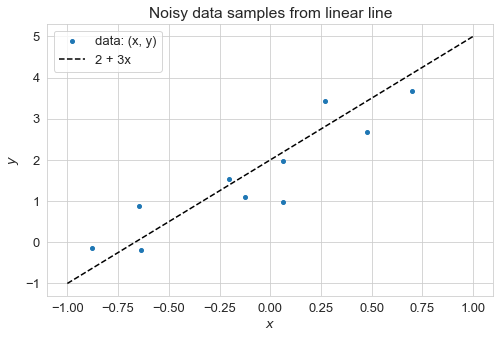

In [39]:
# Define the data
np.random.seed(123)
Ns = 10 # Number of samples
# x_lim = np.array([0, 1])
x_lim = np.array([-1, 1])

# Underlying functional relation
fun = pol
a = [2, 3]
label = f'{a[0]} + {a[1]}x'
# fun = sin
# a = 5
# label = f'sin({a}x)'

# Noise
e_std = 0.5  # Standard deviation of the noise
err = e_std * np.random.randn(Ns)  # Noise

# Features and output
x = np.random.uniform(x_lim[0], x_lim[1], Ns)  # Independent variable x
# x = np.linspace(x_lim[0], x_lim[1], Ns)  # Independent variable x
y = fun(a, x) + err  # Dependent variable

# Show data
X = np.linspace(x_lim[0], x_lim[1], 100)
plt.figure(figsize=(8, 5))
plt.title('Noisy data samples from linear line')
plt.plot(x, y, 'o', ms=4, label='data: (x, y)')
plt.plot(X, fun(a, X), 'k--', label=label)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()
plt.show()

### Полиномиальная регрессия ###

In [45]:
# The number of fetures
Nf = 7
# Stack X with ones to be fitted by vectorized methods such as OLS and gradient descent
F = np.ones_like(x)
for i in range(1, Nf):
    F = np.vstack((F, x**i))
F = F.T
# print(F)
    
# Fit parameters with OLS
Alpha = np.linalg.inv(F.T @ F) @ F.T @ y
print(Alpha)

# Function representing fitted line
f = lambda x: sum([Alpha[i]*x**i for i in range(Nf)])

[   1.15220094    4.77921315   29.39798055  -36.1272129  -134.75066819
   67.44024456  154.82651278]


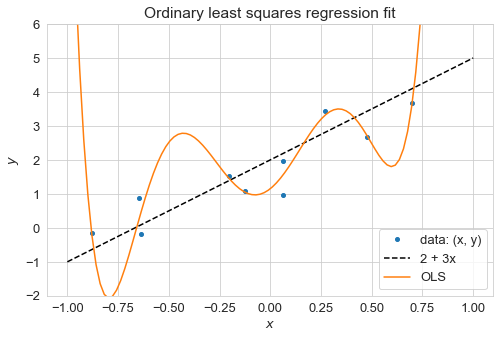

In [49]:
# Show OLS fitted line
plt.figure(figsize=(8, 5))
plt.title('Ordinary least squares regression fit')
plt.plot(x, y, 'o', ms=4, label='data: (x, y)')
plt.plot(X, fun(a, X), 'k--', label=label)
plt.plot(X, f(X), '-', label='OLS')
plt.legend()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.ylim(-2, 6)
plt.show()

---

## Сингулярное разложение ##

Рассмотрим матрицу $F$ размерностью $l \times n$. Для определённости будем считать, строк не меньше чем столбцов и столбцы линейно независимы, т.е. $n \le l$ и $\mathrm{Rg}F = n$.

Произвольную матрицу $F$ размерностью $l \times n$ ранга $n$ можно представить в виде сингулярного разложения (singular value decomposition, SVD)
$$ F = VDU^\top. $$

**Свойства сингулярного разложения:**
1. матрица $D$ размером $n \times n$ диагональна, $ D = \mathrm{diag}\left( \sqrt{\lambda_1}, \ldots, \sqrt{\lambda_n}\right) $, где $\lambda_1, \ldots, \lambda_n$ &mdash; общие ненулевые собственные значения матриц $F^\top F$ и $FF^\top$;
2. матрица $V = (v_1, \ldots, v_n)$ размером $l \times n$ ортогональна, $V^\top V = I_n$, столбцы $v_j$ являются собственными векторами матрицы $FF^\top$, соответствующими $\lambda_1, \ldots, \lambda_n$;
3. матрица $U = (u_1, \ldots, u_n)$ размером $n \times n$ ортогональна, $U^\top U = I_n$, столбцы $u_j$ являются собственными векторами матрицы $F^\top F$, соответствующими $\lambda_1, \ldots, \lambda_n$.

Имея сингулярное разложение, легко записать
 - псевдообратную матрицу:
$$ F^{+} = (UDV^\top VDU^\top)^{-1}UDV^\top = UD^{-1}V^\top = \sum_{j=1}^n \frac{1}{\sqrt{\lambda_j} }u_j v_j^\top;  \label{eq:psevdo}\tag{1} $$
 
 - вектор МНК-решения:
$$ \alpha^* = F^{+} y  = UD^{-1}V^\top y = \sum_{j=1}^n \frac{1}{\sqrt{\lambda_j}}u_j (v_j^\top y);  \label{eq:alpha-res}\tag{2} $$
 
 - вектор $F\alpha^*$ &mdash; МНК-аппроксимацию целевого вектора $y$:
$$ F\alpha^* = P_F y = (VDU^\top)UD^{-1}V^\top y = VV^\top y = \sum_{j=1}^n v_j (v_j^\top y);  \label{eq:F-alpha-res}\tag{3} $$
 
 - норму вектора коэффициентов:
$$ \Vert \alpha^* \Vert^2 = y^\top VD^{-1}U^\top UD^{-1}V^\top y = y^\top VD^{-2}V^\top y = \sum_{j=1}^n \frac{1}{\lambda_j} (v_j^\top y)^2.  \label{eq:alpha-res-norm}\tag{4} $$

In [50]:
V, d, Ut = np.linalg.svd(F, full_matrices=False)
# print(V)
print(f'd = {d}')
# print(Ut.T)

mu = (d[0]/d[-1])**2
print(f'число обусловленности mu = {mu}')

d = [3.35347844 1.83764121 0.84631111 0.34807406 0.13585743 0.02843847
 0.00497056]
число обусловленности mu = 455176.775821429


In [51]:
# Fit parameters with SVD
Alpha_svd = sum([1/d[i] * Ut[i] * (V.T[i] @ y) for i in range(Nf)])
print(Alpha_svd)

# Function representing fitted line
f_svd = lambda x: sum([Alpha_svd[i]*x**i for i in range(Nf)])

[   1.15220094    4.77921315   29.39798055  -36.1272129  -134.75066819
   67.44024456  154.82651278]


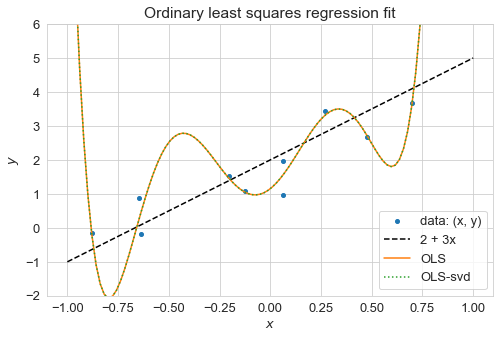

In [52]:
# Show OLS fitted line
plt.figure(figsize=(8, 5))
plt.title('Ordinary least squares regression fit')
plt.plot(x, y, 'o', ms=4, label='data: (x, y)')
plt.plot(X, fun(a, X), 'k--', label=label)
plt.plot(X, f(X), '-', label='OLS')
plt.plot(X, f_svd(X), ':', label='OLS-svd')
plt.legend()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.ylim(-2, 6)
plt.show()

---

## Проблема мультиколлинеарности ##

Если ковариационная матрица $\Sigma = F^\top F$ имеет неполный ранг, то её обращение невозможно.
Тогда приходится отбрасывать линейно зависимые признаки или применять описанные ниже методы &mdash; регуляризацию или метод главных компонент.
На практике чаще встречается проблема *мультиколлинеарности* &mdash; когда матрица $\Sigma$ имеет полный ранг, но близка к некоторой матрице неполного ранга.
Тогда говорят, что $\Sigma$ &mdash; матрица неполного псевдоранга или что она плохо обусловлена.
Геометрически это означает, что объекты выборки сосредоточены вблизи линейного подпространства меньшей размерности $m < n$.
Признаком мультиколлинеарности является наличие у матрицы $\Sigma$ собственных значений, близких к нулю.

**Определение.** *Число обусловленности* матрицы $\Sigma$ есть
$$ \mu(\Sigma) = \left\Vert \Sigma \right\Vert \Vert \Sigma^{-1} \Vert = \frac{\underset{u:\, \Vert u\Vert = 1}{\max} \Vert \Sigma u \Vert}{\underset{u:\, \Vert u\Vert = 1}{\min} \Vert \Sigma u \Vert} = \frac{\lambda_{\max}}{\lambda_{\min}}, $$

где $\lambda_{\max}$ и $\lambda_{\min}$ &mdash; максимальное и минимальное собственные значения матрицы $\Sigma$.

Матрица считается плохо обусловленной, если $\mu(\Sigma) \gtrsim 10^2 \div 10^4$.
Обращение такой матрицы численно неустойчиво.
При умножении обратной матрицы на вектор, $z = \Sigma^{-1}u$, относительная погрешность усиливается в $\mu(\Sigma)$ раз:
$$ \frac{\Vert \delta z \Vert}{\Vert z \Vert} \le \mu(\Sigma) \frac{\Vert \delta u \Vert}{\Vert u \Vert}.$$

Именно это и происходит с МНК-решением в случае плохой обусловленности.
В формуле ([4](#mjx-eqn-eq:alpha-res-norm)) близкие к нулю собственные значения оказываются в знаменателе, в результате увеличивается разброс коэффициентов $\alpha^*$, появляются большие по абсолютной величине положительные и отрицательные коэффициенты.
МНК-решение становится неустойчивым &mdash; малые погрешности измерения признаков или ответов
у обучающих объектов могут существенно повлиять на вектор решения $\alpha^*$, а погрешности измерения признаков у тестового объекта $x$ &mdash; на значения функции регрессии $g(x, \alpha^*)$.
Мультиколлинеарность влечёт не только неустойчивость и переобучение, но и неинтерпретируемость коэффициентов, так как по абсолютной величине коэффициента $\alpha_j$ становится невозможно судить о степени важности признака $f_j$.
Проблема мультиколленеарности никак не проявляется на обучающих данных: вектор $F\alpha^*$ не зависит от собственных значений $\lambda$ (см. формулу ([3](#mjx-eqn-eq:F-alpha-res))).

---

## Гребневая регрессия ##

Для решения проблемы мультиколлинеарности добавим к функционалу $Q$ регуляризатор, штрафующий большие значения нормы вектора весов $\Vert \alpha \Vert$:

$$ Q_\tau(\alpha) = \Vert F\alpha - y \Vert^2 + \tau \Vert \alpha \Vert^2, $$

где $\tau$ &mdash; неотрицательный параметр.
В случае мультиколлинеарности имеется бесконечно много векторов $\alpha$, доставляющих функционалу $Q$ значения, близкие к минимальному.
Штрафное слагаемое выполняет роль регуляризатора, благодаря которому среди них выбирается решение с минимальной нормой.
Приравнивая нулю производную $Q_\tau (\alpha)$ по параметру $\alpha$, находим:

$$ \alpha_\tau^\ast = (F^\top F + \tau I_n)^{-1} F^\top y. $$

Таким образом, перед обращением матрицы к ней добавляется &laquo;гребень&raquo; &mdash; диагональная матрица $\tau I_n$.
Отсюда и название метода &mdash; гребневая регрессия (ridge regression).
При этом все её собственные значения увеличиваются на $\tau$ , а собственные векторы не изменяются.
В результате матрица становится хорошо обусловленной, оставаясь в то же время &laquo;похожей&raquo; на исходную.

Выразим регуляризованное МНК-решение через сингулярное разложение:
$$ \alpha_\tau^* = (UD^2 U^\top + \tau I_n)^{-1} UDV^\top y = U(D^2 + \tau I_n)^{-1} DV^\top y = \sum_{j=1}^n \frac{\sqrt{\lambda_j}}{\lambda_j + \tau} u_j (v_j^\top y).  \label{eq:alpha-tau-res}\tag{5} $$

В формуле \eqref{eq:alpha-tau-res} используется так называемое &laquo;проталкивающее равенство&raquo; ([push-through identity](https://en.wikipedia.org/wiki/Woodbury_matrix_identity)): $A(I + BA)^{-1} = (I + AB)^{-1}A$.

Теперь найдём регуляризованную МНК-аппроксимацию целевого вектора $y$:
$$ F\alpha_\tau^\ast = VDU^\top \alpha_\tau^* = V \mathrm{diag}\left( \frac{\lambda_j}{\lambda_j + \tau} \right) V^\top y = \sum_{j=1}^n \frac{\lambda_j}{\lambda_j + \tau} v_j (v_j^\top y).  \label{eq:F-alpha-tau-res}\tag{6} $$

Как и прежде в ([3](#mjx-eqn-eq:F-alpha-res)), МНК-аппроксимация представляется в виде разложения целевого вектора $y$ по базису собственных векторов матрицы $FF^\top$.
Только теперь проекции на собственные векторы сокращаются, умножаясь на $\frac{\lambda_j}{\lambda_j + \tau} \in (0, 1)$. В сравнении с ([4](#mjx-eqn-eq:alpha-res-norm)) уменьшается и норма вектора коэффициентов:

$$ \Vert \alpha_\tau^{\ast} \Vert^2 = \Vert U(D^2 + \tau I_n)^{-1} DV^\top y \Vert^2  = \sum_{j=1}^n \frac{\lambda_j}{(\lambda_j + \tau)^2} (v_j^\top y)^2 < \sum_{j=1}^n \frac{1}{\lambda_j} (v_j^\top y)^2 = \Vert \alpha^{\ast} \Vert^2. \label{eq:alpha-tau-es-norm}\tag{7} $$


### Выбор константы регуляризации ###

Из формулы \eqref{eq:alpha-tau-res} видно, что при $\tau \to 0$ регуляризованное решение стремится к МНК-решению: $\alpha_\tau^\ast \to \alpha^\ast$.
При $\tau \to \infty$ чрезмерная регуляризации приводит к вырожденному решению: $\alpha^\ast_\tau \to 0$.
Оба крайних случая нежелательны, поэтому оптимальным является некоторое промежуточное значение $\tau^\ast$.
Для его нахождения можно применять, например, скользящий контроль.

Известна практическая рекомендация брать $\tau$ в отрезке [0.1, 0.4], если столбцы матрицы $F$ заранее
стандартизованы (центрированы и нормированы).
Ещё одна эвристика &mdash; выбрать $\tau$ так, чтобы число обусловленности приняло заданное не слишком большое значение: $M_0 = \mu(F^\top F + \tau I_n) = \frac{\lambda_\max + \tau}{\lambda_\min + \tau}$, откуда следует рекомендация $\tau^\ast \approx \lambda_\max/M_0$.

In [55]:
# Fit parameters with ridge regression
M_0 = 1e2    # desired condition number
tau = max(d)**2/M_0
print(f'd = {d}')
print(f'tau = {tau}')
Alpha_r = sum([d[i]/(d[i]**2+tau) * Ut[i] * (V.T[i] @ y) for i in range(Nf)])
print(f'Alpha_r = {Alpha_r}')

# Function representing fitted line
ridge = lambda x: sum([Alpha_r[i]*x**i for i in range(Nf)])

d = [3.35347844 1.83764121 0.84631111 0.34807406 0.13585743 0.02843847
 0.00497056]
tau = 0.11245817628216104
Alpha_r = [1.68081274 2.18712059 0.46765421 0.33858729 0.05017935 0.1247591
 0.03022377]


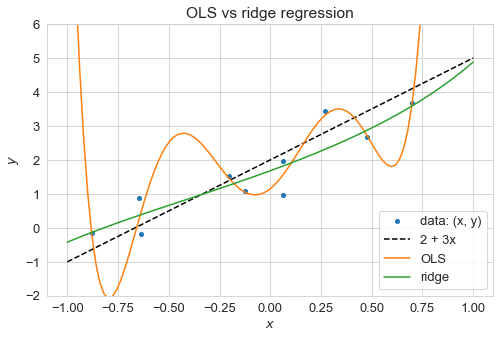

In [56]:
# Show OLS fitted line
plt.figure(figsize=(8, 5))
plt.title('OLS vs ridge regression')
plt.plot(x, y, 'o', ms=4, label='data: (x, y)')
plt.plot(X, fun(a, X), 'k--', label=label)
plt.plot(X, f(X), '-', label='OLS')
plt.plot(X, ridge(X), '-', label='ridge')
plt.legend()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.ylim(-2, 6)
plt.show()

---

## Лассо Тибширани ##

Ещё один метод регуляризации внешне похож на гребневую регрессию, но приводит к качественно иному поведению вектора коэффициентов.
Вместо добавления штрафного слагаемого к функционалу качества вводится ограничение-неравенство, запрещающее слишком большие абсолютные значения коэффициентов:

$$
\left\{
\begin{align}
    & Q(\alpha) = \Vert F\alpha - y \Vert^2 \to \min_\alpha \\
    & \sum\limits_{j=1}^n |\alpha_j| \le \chi
\end{align}
\right.,
\label{eq:lasso}\tag{8}
$$
где $\chi$ &mdash; параметр регуляризации.
При больших значениях $\chi$ ограничение \eqref{eq:lasso} становится строгим неравенством, и решение совпадает с МНК-решением.
Чем меньше $\chi$, тем больше коэффициентов $\alpha_j$ обнуляются.
Происходит отбор (селекция) признаков, поэтому параметр $\chi$ называют ещё *селективностью*.
Образно говоря, параметр $\chi$ зажимает вектор коэффициентов, лишая его избыточных степеней свободы.
Отсюда и название метода &mdash; *лассо* (LASSO, least absolute shrinkage and selection operator). 

In [110]:
import scipy as sp
from scipy.optimize import minimize
from scipy.optimize import NonlinearConstraint

In [66]:
def Q_obj(a):
    '''Q - objective function'''
    return np.linalg.norm((F @ a - y))**2

def constr(a):
    '''Constraint'''
    return np.sum(abs(a))

def solve_lasso(Q_obj, constr, chi):
    '''solve LASSO optimization task'''
    nonlinear_constraint = NonlinearConstraint(constr, 0., chi)
    N_ms = 10   # multistart
    res = []
    for i in range(N_ms):
    # Alpha_0 = np.zeros(Nf)    # initial approximation
        Alpha_0 = 10*np.random.rand(Nf) - 5
        res.append(minimize(Q_obj, Alpha_0, method='SLSQP', constraints=nonlinear_constraint))
    argmin = np.argmin([item.fun for item in res])
    return res[argmin]

In [85]:
# solve LASSO optimization task
chi = 5    # the max constraint for the decision vector
res = solve_lasso(Q_obj, constr, chi)
Alpha_l = res.x
lasso = lambda x: sum([Alpha_l[i]*x**i for i in range(Nf)])

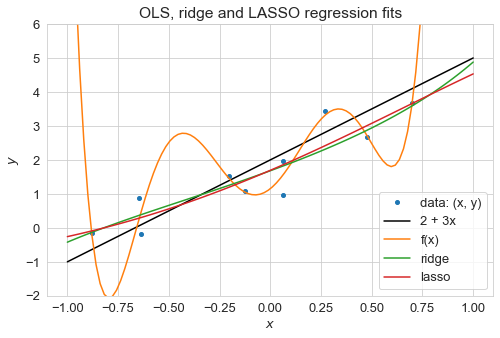

In [86]:
# Show OLS fitted line
plt.figure(figsize=(8, 5))
plt.title('OLS, ridge and LASSO regression fits')
plt.plot(x, y, 'o', ms=4, label='data: (x, y)')
plt.plot(X, fun(a, X), 'k-', label=label)
plt.plot(X, f(X), '-', label='f(x)')
plt.plot(X, ridge(X), '-', label='ridge')
plt.plot(X, lasso(X), '-', label='lasso')
plt.legend()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.ylim(-2, 6)
plt.show()

In [87]:
print(f'OLS:   a = {Alpha}  \n norm(a) = {constr(Alpha)},   Q = {Q_obj(Alpha_svd)}\n')
print(f'ridge: a = {Alpha_r}\n norm(a) = {constr(Alpha_r)}, Q = {Q_obj(Alpha_r)}\n')
print(f'LASSO: a = {Alpha_l}\n norm(a) = {constr(Alpha_l)}, Q = {Q_obj(Alpha_l)}\n')

OLS:   a = [   1.15220094    4.77921315   29.39798055  -36.1272129  -134.75066819
   67.44024456  154.82651278]  
 norm(a) = 428.4740330707647,   Q = 1.4726404272486608

ridge: a = [1.68081274 2.18712059 0.46765421 0.33858729 0.05017935 0.1247591
 0.03022377]
 norm(a) = 4.879337051881616, Q = 2.8531524369506758

LASSO: a = [ 1.69318175e+00  2.55795749e+00  5.14558479e-01 -1.63160618e-01
 -7.11383136e-02  2.70913139e-06 -6.41631237e-07]
 norm(a) = 5.0, Q = 2.7611788694491315



---

## Сравнение лассо и гребневой регрессии ##

Оба метода успешно решают проблему мультиколлинеарности.
Гребневая регрессия использует все признаки, стараясь &laquo;выжать максимум&raquo; из имеющейся информации. Лассо производит отбор признаков, что предпочтительнее, если среди признаков есть шумовые или измерения признаков связаны с ощутимыми затратами.

Ниже приводится сравнение гребневой регресии и лассо.
Ослабление регуляризации (рост параметров $\sigma = 1/\tau$ и $\chi$) ведёт к уменьшению ошибки на обучении и увеличению нормы вектора коэффициентов.
При этом ошибка на контроле в какой-то момент проходит через минимум, и далее только возрастает &mdash; это и есть переобучение (проверить самостоятельно).

In [107]:
eps = 1e-2
Sigma = np.arange(eps, 1e3*eps, eps)
AA = np.empty((len(Sigma), len(d)))
for i, sigma in enumerate(Sigma):
    AA[i] = sum([d[i]/(d[i]**2+1/sigma) * Ut[i] * (V.T[i] @ y) for i in range(Nf)])

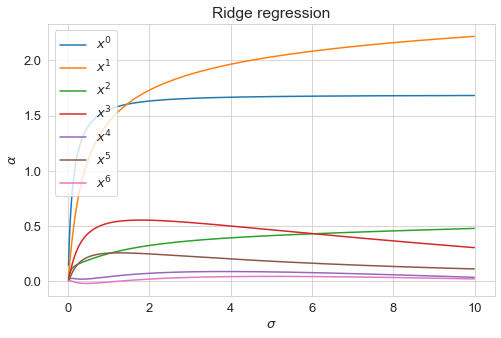

In [108]:
# Show OLS fitted line
plt.figure(figsize=(8, 5))
plt.title('Ridge regression')

for i, aa in enumerate(AA.T):
    plt.plot(Sigma, aa, '-', label=f'$x^{i}$')
plt.xlabel('$\sigma$')
plt.ylabel(r'$\alpha$')
# plt.ylim((1, 6))
plt.legend(loc=2)
plt.show()

In [89]:
Chi = np.arange(1, 11, 1)
BB = np.empty((len(Chi), len(d)))

for i, chi in enumerate(Chi):
    res = solve_lasso(Q_obj, constr, chi)
    BB[i] = res.x
# print(res) 

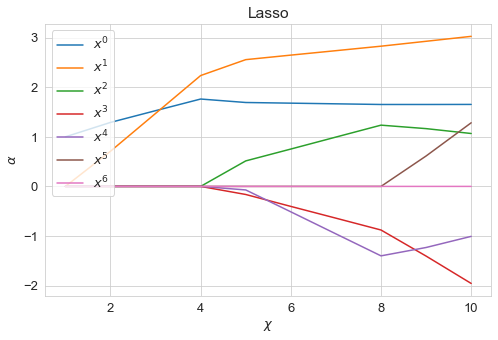

In [92]:
# Show OLS fitted line
plt.figure(figsize=(8, 5))
plt.title('Lasso')

for i, bb in enumerate(BB.T):
    plt.plot(Chi, bb, '-', label=f'$x^{i}$')
plt.xlabel(r'$\chi$')
plt.ylabel(r'$\alpha$')
# plt.ylim((1, 6))
plt.legend(loc=2)
plt.show()

---

### Проверка сингулярного разложения

In [59]:
A1 = np.dot(F, F.T)
w1, V1 = LA.eig(A1)
ind = np.argsort(w1)[::-1]

for i, v in enumerate(V.T):
    print('SVD:')
    print('l = ', d[i]**2)
#     print('s = ', v)
#     print('Ax = ', np.dot(A1, v))
#     print('lx = ', d[i]**2 * v)
    
    j = ind[i]
    v1 = V1.T[j]
    print('EIG:')
    print('l = ', w1[j])
#     print('s = ', v1)
#     print('Ax = ', np.dot(A1, v1))
#     print('lx = ', w1[j]*v)
    print()

SVD:
l =  56396.11957193667
EIG:
l =  (56396.11957193666+0j)

SVD:
l =  147.45508546673742
EIG:
l =  (147.45508546673727+0j)



In [141]:
A2 = np.dot(F.T, F)

# print(A1)
w1, V1 = LA.eig(A1)
print(w1)
print(V1)
# print(np.linalg.matrix_rank(V1))
# print(np.linalg.det(V1))
# for v in v1:
#     print(np.linalg.norm(v))

# print(A2)
w2, V2 = LA.eig(A2)
print(w2)
print(V2)
# print(np.linalg.matrix_rank(V2))

[ 4.64536764e+00 -3.87741229e-17  1.84954099e-01  4.25712354e-01
  3.78109451e-01]
[[-0.24814526 -0.24761258  0.79763217 -0.48969659  0.03304716]
 [-0.49266878  0.74398511  0.05781575 -0.00215731  0.44767881]
 [-0.42246294  0.21368211 -0.2239364  -0.3122153  -0.79261536]
 [-0.52309144 -0.26731497  0.22769751  0.76050855 -0.15715801]
 [-0.49356035 -0.51774205 -0.50837643 -0.29041512  0.38151516]]
[4.64536764 0.1849541  0.37810945 0.42571235]
[[ 0.39879149  0.48800125 -0.71762744 -0.29636292]
 [ 0.39229372 -0.8055876  -0.40497916  0.1820059 ]
 [ 0.4746513  -0.1640084   0.45574257 -0.73491911]
 [ 0.67954185  0.2932314   0.33660281  0.58218276]]


In [138]:
for i, v in enumerate(V1.T):
    print(np.dot(A1, v))
    print(w1[i]*v)

[-1.15272598 -2.28862759 -1.96249567 -2.42995204 -2.29276927]
[-1.15272598 -2.28862759 -1.96249567 -2.42995204 -2.29276927]
[-3.33066907e-16 -1.11022302e-16 -3.33066907e-16 -2.22044605e-16
 -1.11022302e-16]
[ 9.60096057e-18 -2.88473700e-17 -8.28533652e-18  1.03649035e-17
  2.00749939e-17]
[ 0.14752534  0.01069326 -0.04141796  0.04211359 -0.0940263 ]
[ 0.14752534  0.01069326 -0.04141796  0.04211359 -0.0940263 ]
[-0.20846989 -0.00091839 -0.13291391  0.32375789 -0.1236333 ]
[-0.20846989 -0.00091839 -0.13291391  0.32375789 -0.1236333 ]
[ 0.01249544  0.16927159 -0.29969536 -0.05942293  0.14425449]
[ 0.01249544  0.16927159 -0.29969536 -0.05942293  0.14425449]


In [101]:
# D = np.vstack([np.diag(d), np.zeros((N_obj-len(s), N_features))])
D = np.diag(d)
print(D)
# display(np.dot(np.dot(V, D), U.T) - F)

[[1.88687797 0.         0.         0.        ]
 [0.         0.64170376 0.         0.        ]
 [0.         0.         0.55692405 0.        ]
 [0.         0.         0.         0.28552753]]


## Метод главных компонент ##

In [107]:
G = np.dot(V, D)
display(G)
L = np.dot(G.T, G)
display(L)
display(L.diagonal())

array([[-0.53259741,  0.30490545,  0.31460882,  0.17495239],
       [-1.03557852, -0.10497457,  0.29855246, -0.17708409],
       [-0.92191585,  0.41149424, -0.30727702, -0.06100885],
       [-1.16374257, -0.37211451, -0.16623161,  0.12584425]])

array([[ 3.56030846e+00,  5.55111512e-17,  1.66533454e-16,
        -2.77555756e-17],
       [ 5.55111512e-17,  4.11783713e-01,  1.59594560e-16,
         6.93889390e-18],
       [ 1.66533454e-16,  1.59594560e-16,  3.10164396e-01,
        -1.38777878e-17],
       [-2.77555756e-17,  6.93889390e-18, -1.38777878e-17,
         8.15259712e-02]])

array([3.56030846, 0.41178371, 0.3101644 , 0.08152597])

## Литература ##

1. Воронцов К.В. [Математические методы обучения по прецендентам (теория обучения машин)](http://www.machinelearning.ru/wiki/images/6/6d/Voron-ML-1.pdf). 141 c.

In [111]:
# Versions used
print('Python: {}.{}.{}'.format(*sys.version_info[:3]))
print('numpy: {}'.format(np.__version__))
print('matplotlib: {}'.format(matplotlib.__version__))
print('seaborn: {}'.format(sns.__version__))
print('scipy: {}'.format(sp.__version__))

Python: 3.7.6
numpy: 1.18.1
matplotlib: 3.1.3
seaborn: 0.10.0
scipy: 1.4.1
